## Anna's capstone

In [1]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


### we will make analysis about if high housing price will correlated with resturant

In [ ]:
!pip install geopy
!pip install beautifulsoup4
!pip install lxml
!pip install geocoder

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## query data from foursqure

In [2]:
CLIENT_ID = 'ABE0AWIWDUYC5SLEXSRMT5FOJD50JBO4ESKYLSAJMDCLYQPO' # your Foursquare ID
CLIENT_SECRET = 'GZCYJ2HQRWE5IDA5TIZT2BEO2QLGLYMJTHIYQRNR0CVWEM0G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ABE0AWIWDUYC5SLEXSRMT5FOJD50JBO4ESKYLSAJMDCLYQPO
CLIENT_SECRET:GZCYJ2HQRWE5IDA5TIZT2BEO2QLGLYMJTHIYQRNR0CVWEM0G


In [3]:
# refer all zipcode in sf: https://www.zip-codes.com/city/ca-san-francisco.asp
zipcode_list = [94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112,
               94114, 94115, 94116, 94117, 94118, 94119, 94120, 94121, 94122, 94123,
               94124, 94125, 94126, 94127, 94128, 94129, 94130, 94131, 94132, 94133,
               94134, 94137, 94139, 94140, 94141, 94142, 94143, 94144, 94145, 94146, 
               94147, 94151, 94158, 94159, 94160, 94161, 94163, 94164, 94172, 94177, 94188]

In [28]:
# record housing price as of June 2021 redfin
value = [1285, 905, 645, 1000, 1146, 1480, 1170, 1500, 1160, 1400, 1900, 1600,1900, 
        1700, 1950, 1842, 1786, 2760, 975, 2280, 0, 0, 0, 2051, 1350, 1300, 1136.5, 1593.75]

In [6]:
# data download from https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html
lat_lon = pd.read_csv('./2020_Gaz_zcta_national.txt', delimiter = "\t")
lat_lon.head()

GEOID      ALAND   AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  \
0    601  166659744   799292      64.348        0.309  18.180555   
1    602   79307538  4428428      30.621        1.710  18.361945   
2    603   81887203   181412      31.617        0.070  18.455183   
3    606  109579950    12487      42.309        0.005  18.158327   
4    610   93013430  4172059      35.913        1.611  18.294032   

   INTPTLONG                                                                                                                                    
0                                         -66.749961                                                                                            
1                                         -67.175597                                                                                            
2                                         -67.119887                                                                                            
3                                         -66.932928                                                                                            
4                                         -67.127156

In [7]:
sf_loc = lat_lon[lat_lon['GEOID'].isin(zipcode_list)]

In [8]:
sf_loc.head()

GEOID    ALAND  AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  \
30987  94102  1732577       0       0.669        0.000  37.779583   
30988  94103  3518047       0       1.358        0.000  37.773152   
30989  94104   200857       0       0.078        0.000  37.791412   
30990  94105   942025  223684       0.364        0.086  37.789649   
30991  94107  4647665  227634       1.794        0.088  37.760460   

       INTPTLONG                                                                                                                                    
30987                                        -122.419340                                                                                            
30988                                        -122.411163                                                                                            
30989                                        -122.402129                                                                                            
30990                                        -122.393067                                                                                            
30991                                        -122.399724

In [9]:
names = sf_loc.GEOID.to_list()
latitudes = sf_loc.INTPTLAT.to_list()
longitudes = sf_loc[sf_loc.columns[-1]].to_list()

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
sf_venue = getNearbyVenues(names,latitudes, longitudes, radius = 1000)

94102
94103
94104
94105
94107
94108
94109
94110
94111
94112
94114
94115
94116
94117
94118
94121
94122
94123
94124
94127
94128
94129
94130
94131
94132
94133
94134
94158


In [12]:
sf_venue.shape

(2332, 7)

In [13]:
sf_venue.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         94102              37.779583              -122.41934   
1         94102              37.779583              -122.41934   
2         94102              37.779583              -122.41934   
3         94102              37.779583              -122.41934   
4         94102              37.779583              -122.41934   

                            Venue  Venue Latitude  Venue Longitude  \
0  Louise M. Davies Symphony Hall       37.777976      -122.420157   
1        War Memorial Opera House       37.778601      -122.420816   
2                  Herbst Theater       37.779548      -122.420953   
3            San Francisco Ballet       37.778580      -122.420798   
4                Asian Art Museum       37.780178      -122.416505   

  Venue Category  
0   Concert Hall  
1    Opera House  
2   Concert Hall  
3   Dance Studio  
4     Art Museum

In [14]:
sf_cluster = sf_venue.loc[:,['Venue Latitude','Venue Longitude']]

In [15]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [16]:
sse = calculate_WSS(sf_cluster.values, 20)

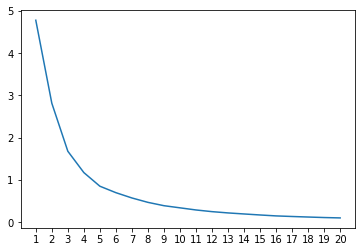

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
xint = range(1, math.ceil(len(sse))+1)
x = np.linspace(1, len(sse)+1, len(sse), endpoint = False)
plt.xticks(xint)
plt.plot(x, sse)

### then we can find the elbow is 5. we will use 5 as best k

In [18]:
k=5
sf_cluster = sf_venue.loc[:,['Venue Latitude','Venue Longitude']]
kmeans = KMeans(n_clusters = k,random_state=0).fit(sf_cluster)
kmeans.labels_
sf_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [20]:
sf_data = pd.merge(sf_venue, sf_cluster, on=['Venue Latitude','Venue Longitude'])

In [21]:
sf_data.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         94102              37.779583              -122.41934   
1         94102              37.779583              -122.41934   
2         94102              37.779583              -122.41934   
3         94102              37.779583              -122.41934   
4         94102              37.779583              -122.41934   

                            Venue  Venue Latitude  Venue Longitude  \
0  Louise M. Davies Symphony Hall       37.777976      -122.420157   
1        War Memorial Opera House       37.778601      -122.420816   
2                  Herbst Theater       37.779548      -122.420953   
3            San Francisco Ballet       37.778580      -122.420798   
4                Asian Art Museum       37.780178      -122.416505   

  Venue Category  Cluster Labels  
0   Concert Hall               0  
1    Opera House               0  
2   Concert Hall               0  
3   Dance Studio               0  
4     Art Museum               0

### process all necessary data

In [23]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_data['Neighborhood'] 

# move neighborhood column to the first column
list_column = sf_onehot.columns.tolist()
number_column = int(list_column.index('Neighborhood'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
sf_onehot = sf_onehot[list_column]

sf_onehot.head()

Neighborhood  Acai House  Accessories Store  Adult Boutique  \
0         94102           0                  0               0   
1         94102           0                  0               0   
2         94102           0                  0               0   
3         94102           0                  0               0   
4         94102           0                  0               0   

   African Restaurant  Airport Lounge  Airport Service  Alternative Healer  \
0                   0               0                0                   0   
1                   0               0                0                   0   
2                   0               0                0                   0   
3                   0               0                0                   0   
4                   0               0                0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           1                    0                 0   

   Athletics & Sports  Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  \
0                   0            0                0          0           0   
1                   0            0                0          0           0   
2                   0            0                0          0           0   
3                   0            0                0          0           0   
4                   0            0                0          0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                   0      0                0         0            0   
1                   0      0                0         0            0   
2                   0      0                0         0            0   
3                   0      0                0         0            0   
4                   0      0                0         0            0   

   Bike Shop  Board Shop  Bookstore  Boutique  Bowling Alley  \
0          0           0          0         0              0   
1          0           0          0         0              0   
2          0           0          0         0              0   
3          0           0          0         0              0   
4          0           0          0         0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  \
0                     0               0        0                0   
1                     0               0        0                0   
2                     0               0        0                0   
3                     0               0        0                0   
4                     0               0        0                0   

   Burger Joint  Burmese Restaurant  Burrito Place  Bus Line  Bus Station  \
0             0                   0              0   

In [24]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()

In [25]:
sf_grouped.head()

Neighborhood  Acai House  Accessories Store  Adult Boutique  \
0         94102    0.000000           0.008264             0.0   
1         94103    0.000000           0.000000             0.0   
2         94104    0.014563           0.000000             0.0   
3         94105    0.018750           0.000000             0.0   
4         94107    0.000000           0.009174             0.0   

   African Restaurant  Airport Lounge  Airport Service  Alternative Healer  \
0                 0.0             0.0              0.0                 0.0   
1                 0.0             0.0              0.0                 0.0   
2                 0.0             0.0              0.0                 0.0   
3                 0.0             0.0              0.0                 0.0   
4                 0.0             0.0              0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0             0.000000      0.000000     0.0                0.000000   
1             0.000000      0.000000     0.0                0.000000   
2             0.004854      0.000000     0.0                0.000000   
3             0.006250      0.000000     0.0                0.012500   
4             0.009174      0.009174     0.0                0.009174   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0     0.000000    0.016529             0.000000               0.0   
1     0.024590    0.016393             0.000000               0.0   
2     0.000000    0.019417             0.000000               0.0   
3     0.012500    0.025000             0.012500               0.0   
4     0.027523    0.000000             0.009174               0.0   

   Athletics & Sports  Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  \
0                 0.0          0.0              0.0        0.0    0.008264   
1                 0.0          0.0              0.0        0.0    0.000000   
2                 0.0          0.0              0.0        0.0    0.000000   
3                 0.0          0.0              0.0        0.0    0.000000   
4                 0.0          0.0              0.0        0.0    0.000000   

     Bakery  Bank       Bar  Baseball Field  Baseball Stadium  \
0  0.016529   0.0  0.000000             0.0               0.0   
1  0.016393   0.0  0.016393             0.0               0.0   
2  0.000000   0.0  0.000000             0.0               0.0   
3  0.012500   0.0  0.000000             0.0               0.0   
4  0.000000   0.0  0.018349             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0  0.057851   
1               0.0                 0.0    0.0              0.0  0.057377   
2               0.0                 0.0    0.0              0.0  0.000000   
3               0.0                 0.0    0.0              0.0  0.012500   
4               0.0                 0.0    0.0              0.0  0.000000   

   Beer Garden  Bike Shop  Board Shop  Bookstore  Boutique  Bowling Alley  \
0     0.008264        0.0         0.0   0.000000  0.008264            0.0   
1     0.000000        0.0         0.0   0.000000  0.000000            0.0   
2     0.000000        0.0         0.0   0.024272  0.019417            0.0   
3     0.000000        0.0         0.0   0.025000  0.000000            0.0   
4     0.000000        0.0         0.0   0.009174  0.000000            0.0   

   Brazilian Restaurant  Breakfast Spot   Brewery  Bubble Tea Shop  \
0              0.000000        0.000000  0.000000         0.000000   
1              0.000000        0.000000  0.008197         0.000000   
2              0.000000        0.000000  0.000000         0.009709   
3              0.000000        0.000000  0.000000         0.000000   
4              0.009174        0.027523  0.036697         0.027523   

   Burger Joint  Burmese Restaurant  Burrito Place  Bus Line  Bus Station  \
0    

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighborhood_venues_sorted = pd.DataFrame(columns=columns)
Neighborhood_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    Neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

Neighborhood_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         94102              Beer Bar               Theater   
1         94103           Coffee Shop             Nightclub   
2         94104           Men's Store           Coffee Shop   
3         94105           Coffee Shop            Food Truck   
4         94107                  Café           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue          5th Most Common Venue  \
0           Coffee Shop          Cocktail Bar  Vegetarian / Vegan Restaurant   
1              Beer Bar               Theater                        Gay Bar   
2   Japanese Restaurant                   Gym                          Hotel   
3    Seafood Restaurant   Japanese Restaurant                            Gym   
4    Mexican Restaurant      Sushi Restaurant                           Park   

  6th Most Common Venue     7th Most Common Venue  8th Most Common Venue  \
0  Marijuana Dispensary                  Wine Bar  Vietnamese Restaurant   
1          Cocktail Bar              Dance Studio   Marijuana Dispensary   
2           Salad Place  Mediterranean Restaurant       Sushi Restaurant   
3           Salad Place              Dessert Shop              Bookstore   
4               Brewery            Sandwich Place        Bubble Tea Shop   

  9th Most Common Venue    10th Most Common Venue  
0      Sushi Restaurant              Dance Studio  
1  Gym / Fitness Center                       Gym  
2            Food Truck   New American Restaurant  
3            Art Museum  Mediterranean Restaurant  
4        Breakfast Spot               Art Gallery

In [29]:
Neighborhood_venues_sorted['housing_price(K)'] = value

In [30]:
Neighborhood_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         94102              Beer Bar               Theater   
1         94103           Coffee Shop             Nightclub   
2         94104           Men's Store           Coffee Shop   
3         94105           Coffee Shop            Food Truck   
4         94107                  Café           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue          5th Most Common Venue  \
0           Coffee Shop          Cocktail Bar  Vegetarian / Vegan Restaurant   
1              Beer Bar               Theater                        Gay Bar   
2   Japanese Restaurant                   Gym                          Hotel   
3    Seafood Restaurant   Japanese Restaurant                            Gym   
4    Mexican Restaurant      Sushi Restaurant                           Park   

  6th Most Common Venue     7th Most Common Venue  8th Most Common Venue  \
0  Marijuana Dispensary                  Wine Bar  Vietnamese Restaurant   
1          Cocktail Bar              Dance Studio   Marijuana Dispensary   
2           Salad Place  Mediterranean Restaurant       Sushi Restaurant   
3           Salad Place              Dessert Shop              Bookstore   
4               Brewery            Sandwich Place        Bubble Tea Shop   

  9th Most Common Venue    10th Most Common Venue  housing_price(K)  
0      Sushi Restaurant              Dance Studio            1285.0  
1  Gym / Fitness Center                       Gym             905.0  
2            Food Truck   New American Restaurant             645.0  
3            Art Museum  Mediterranean Restaurant            1000.0  
4        Breakfast Spot               Art Gallery            1146.0

In [31]:
sf_data_cluster_group=sf_data.loc[:,['Neighborhood','Cluster Labels']].groupby('Neighborhood').mean().reset_index()

In [32]:
sf_data_cluster_group['Cluster Labels'] = np.floor(sf_data_cluster_group['Cluster Labels'])
sf_data_cluster_group.head()

Neighborhood  Cluster Labels
0         94102             0.0
1         94103             0.0
2         94104             0.0
3         94105             0.0
4         94107             0.0

In [33]:
sf_final = pd.merge(Neighborhood_venues_sorted,sf_data_cluster_group,on='Neighborhood')
sf_final.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         94102              Beer Bar               Theater   
1         94103           Coffee Shop             Nightclub   
2         94104           Men's Store           Coffee Shop   
3         94105           Coffee Shop            Food Truck   
4         94107                  Café           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue          5th Most Common Venue  \
0           Coffee Shop          Cocktail Bar  Vegetarian / Vegan Restaurant   
1              Beer Bar               Theater                        Gay Bar   
2   Japanese Restaurant                   Gym                          Hotel   
3    Seafood Restaurant   Japanese Restaurant                            Gym   
4    Mexican Restaurant      Sushi Restaurant                           Park   

  6th Most Common Venue     7th Most Common Venue  8th Most Common Venue  \
0  Marijuana Dispensary                  Wine Bar  Vietnamese Restaurant   
1          Cocktail Bar              Dance Studio   Marijuana Dispensary   
2           Salad Place  Mediterranean Restaurant       Sushi Restaurant   
3           Salad Place              Dessert Shop              Bookstore   
4               Brewery            Sandwich Place        Bubble Tea Shop   

  9th Most Common Venue    10th Most Common Venue  housing_price(K)  \
0      Sushi Restaurant              Dance Studio            1285.0   
1  Gym / Fitness Center                       Gym             905.0   
2            Food Truck   New American Restaurant             645.0   
3            Art Museum  Mediterranean Restaurant            1000.0   
4        Breakfast Spot               Art Gallery            1146.0   

   Cluster Labels  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

### results analysis

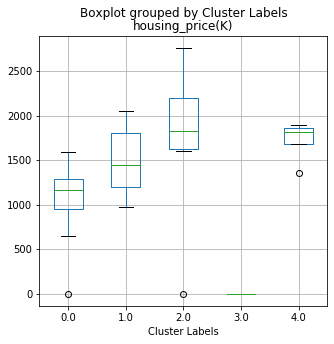

In [34]:
sf_final.boxplot(column=['housing_price(K)'],by='Cluster Labels',figsize=(5,5))

In [38]:
count_venue = sf_final.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

In [39]:
#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue  Airport Lounge  Bakery  Beer Bar  Café  \
0                                   0       0         1     1   
1                                   0       0         0     0   
2                                   0       1         0     0   
3                                   1       0         0     0   
4                                   0       1         0     0   

1st Most Common Venue  Chinese Restaurant  Coffee Shop  Food Truck  Gay Bar  \
0                                       0            3           1        0   
1                                       0            0           0        1   
2                                       0            0           0        0   
3                                       0            0           0        0   
4                                       3            0           0        0   

1st Most Common Venue  Gym / Fitness Center  Japanese Restaurant  Men's Store  \
0                                         0                    0            2   
1                                         0                    0            0   
2                                         1                    1            0   
3                                         0                    0            0   
4                                         0                    0            0   

1st Most Common Venue  Mexican Restaurant  Park  Pizza Place  \
0                                       0     2            1   
1                                       2     2            0   
2                                       0     2            0   
3                                       0     0            0   
4                                       0     0            0   

1st Most Common Venue  Southern / Soul Food Restaurant  Trail  
0                                                    0      0  
1                                                    1      0  
2                                                    0      1  
3                                                    0      0  
4                                                    0      0

Text(0, 0.5, 'Clusters')

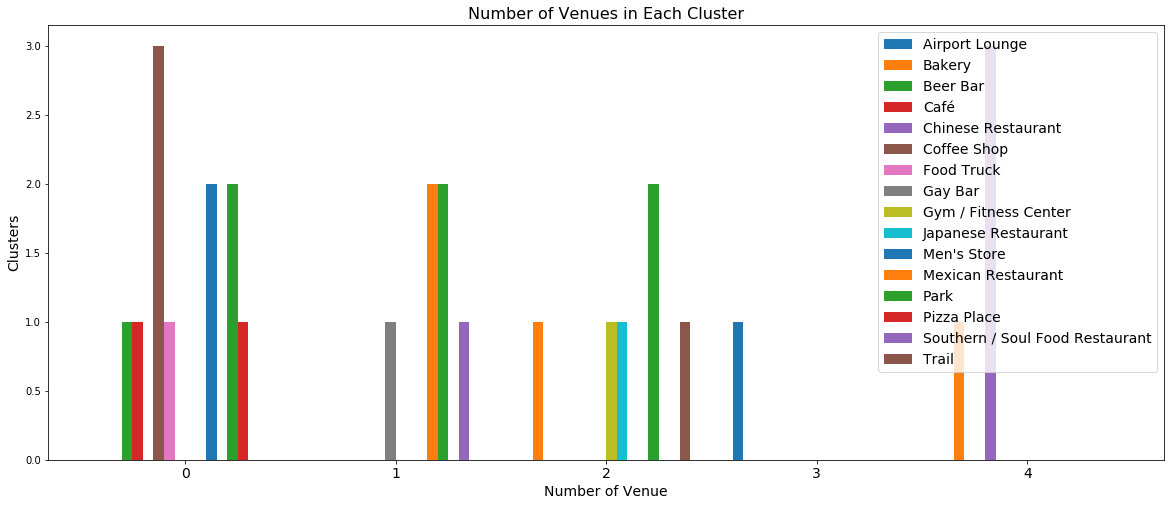

In [40]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

In [41]:
latitude = 37.7749 
longitude = -122.4194
# create map
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(sf_data['Neighborhood Latitude'], sf_data['Neighborhood Longitude'], sf_data['Neighborhood'], sf_data['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters